# Comparing the competing impacts of binary physics and galactic potentials

## The goal and plan

In this case study, the question we want to answer is **"what is the relative importance of binary physics and the galactic potential in determining the spatial distributions of massive stars"**. In order to do this, let's compare the final galactocentric $x$ and $z$ positions of massive stars at present day (i.e. stars with more than $7 {\rm M_\odot}$ and a stellar type less than $10$), varying the mean magnitude of supernova natal kicks and the galactic potential used.

In [7]:
import cogsworth
import numpy as np
import astropy.units as u
import gala.potential as gp
from gala.units import galactic
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [8]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 20

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.7 * fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.7 * fs,
          'ytick.labelsize': 0.7 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [9]:
import pandas as pd
pd.options.display.max_columns = 999

## Simulate the populations
To start, let's simulate the population. Specifically, let's simulate a population of stars formed in the last billion years in the Milky Way with a 100% binary fraction.

In [10]:
# only want the last 1 Gyr of star formation
max_ev_time = 1000 * u.Myr

### Define some star formation histories and potentials

First, let's define two different SFH and potential models that approximately represent a quasi-isothermal MW thin disc and the Carina dwarf galaxy, but using a fixed metallicity for both.

In [11]:
# use a quasi-isothermal disk model for the star formation history, but with a more recent history
class RecentDisc(cogsworth.sfh.QuasiIsothermalDisk):
    def draw_lookback_times(self, size=None, component="low_alpha_disc"):
        U = np.random.rand(size)
        norm = 1 / (self.tsfr * np.exp(-self.galaxy_age / self.tsfr) * (np.exp(max_ev_time / self.tsfr) - 1))
        tau = self.tsfr * np.log((U * np.exp(self.galaxy_age / self.tsfr)) / (norm * self.tsfr) + 1)

        return tau
    
    def get_metallicity(self):
        return np.repeat(0.02, len(self)) * u.dimensionless_unscaled

# simply the Milky Way potential
pot = gp.MilkyWayPotential2022()

In [12]:
# approximate the Carina dwarf galaxy recent star formation history
class Carina(cogsworth.sfh.SpheroidalDwarf):
    def __init__(self, size, mass=8.67e8 * u.Msun, J_0_star=0.677 * u.kpc*u.km/u.s,
                       alpha=0.946, eta=0.5, **kwargs):
        super().__init__(size=size, mass=mass, J_0_star=J_0_star, alpha=alpha, eta=eta, **kwargs)

    def draw_lookback_times(self, size=None, component="low_alpha_disc"):
        U = np.random.rand(size)
        norm = 1 / (self.tsfr * np.exp(-self.galaxy_age / self.tsfr) * (np.exp(max_ev_time / self.tsfr) - 1))
        tau = self.tsfr * np.log((U * np.exp(self.galaxy_age / self.tsfr)) / (norm * self.tsfr) + 1)

        return tau
    
    def get_metallicity(self):
        return np.repeat(0.02, len(self)) * u.dimensionless_unscaled
    
# use a simple NFW potential for the Carina dwarf galaxy
carina_pot = gp.NFWPotential(m=8.67e8 * u.Msun, r_s=1.0, units=galactic)

### Sample initial conditions

For the most consistent comparison, we'll use the same initial conditions for each population. Let's start by sampling these for the base population.

In [96]:
base_pop = cogsworth.pop.Population(
    10_000_000,
    processes=80,
    m1_cutoff=7,
    sfh_model=RecentDisc,
    galactic_potential=pot,
    max_ev_time=max_ev_time,
    BSE_settings={"binfrac": 1.0, "cemergeflag": 0},
    use_default_BSE_settings=True,
    store_entire_orbits=False
)
base_pop.sample_initial_binaries()

### Evolve binary physics variations

Now let's evolve this for two choices of the mean supernova natal kick magnitude:

- the default choice of $265 \, {\rm km /s}$
- a variation with extremely strong kicks with a mean of $1000 \, {\rm km /s}$

In [119]:
# copy the base population
disc_fiducial = base_pop[:]
disc_fiducial.perform_stellar_evolution()

In [120]:
disc_alternate = disc_fiducial[:]

# adjust sigma for both types of kicks
disc_alternate.BSE_settings["alpha1"] = 0.1

# evolve both
disc_alternate.perform_stellar_evolution()

### Mask the populations

Mask the population to only retain systems that experienced a supernova and are now either in a bound binary with a star or are a star from a disrupted binary.

In [18]:
KSTAR_MAX = 10

def mask_population(p):
    # get the binarys that have at least one SN
    has_sn_bin_nums = p.bpp[p.bpp["evol_type"].isin([15, 16])]["bin_num"].unique()
    
    # reduce population
    p_sn = p[has_sn_bin_nums]
    
    # get bound/merged binaries that have a star in them
    stars_in_binaries = (p_sn.final_bpp["sep"] >= 0.0) & ((p_sn.final_bpp["kstar_1"] < KSTAR_MAX)
                                                       |  (p_sn.final_bpp["kstar_2"] < KSTAR_MAX))
    
    # get disrupted binaries where at least one component is still a star
    disrupted_stars = (p_sn.final_bpp["sep"] == -1) & ((p_sn.final_bpp["kstar_1"] < KSTAR_MAX)
                                                     | (p_sn.final_bpp["kstar_2"] < KSTAR_MAX))
    return p_sn[p_sn.bin_nums[stars_in_binaries | disrupted_stars]]

In [121]:
disc_fiducial = mask_population(disc_fiducial)

In [122]:
disc_alternate = mask_population(disc_alternate)

### Integrate through different potentials
Now, for each value of sigma we can evolve it through both the disc and dwarf galaxy.

In [124]:
# copy the other populations
carina_fiducial = disc_fiducial[:]
carina_alternate = disc_alternate[:]

# change the SFH and potential
carina_fiducial.sfh_model = Carina
carina_fiducial.galactic_potential = carina_pot
carina_alternate.sfh_model = Carina
carina_alternate.galactic_potential = carina_pot

# resample the star formation history
carina_fiducial.sample_initial_galaxy()
carina_alternate.sample_initial_galaxy()

In [125]:
# evolve them all through their respective galaxies
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message=".*bad orbit.*")
    disc_fiducial.perform_galactic_evolution()
    disc_alternate.perform_galactic_evolution()
    carina_fiducial.perform_galactic_evolution()
    carina_alternate.perform_galactic_evolution()

11633it [00:01, 7824.84it/s]                          


9135it [00:01, 5991.51it/s]                          


11633it [00:01, 6040.69it/s]                          


9135it [00:00, 9710.48it/s]                           


In [13]:
%%time
disc_fiducial = cogsworth.pop.load("disc_fiducial.h5")
disc_alternate = cogsworth.pop.load("disc_alternate.h5")
carina_fiducial = cogsworth.pop.load("carina_fiducial.h5")
carina_alternate = cogsworth.pop.load("carina_alternate.h5")

CPU times: user 197 ms, sys: 92.2 ms, total: 289 ms
Wall time: 811 ms


## Get present day positions of stars

Now we need some functions to split the populations into the correct subpopulations and also a way to access the final positions of only stars. The rest of the code in this case study follows very similarly to the previous one.

In [15]:
def get_x_z(p):
    """Get the final x-z positions of the stars in the population"""
    # bound systems need at least one star
    bound_pos = p.final_pos[:len(p)][~p.disrupted & ((p.final_bpp["kstar_1"] <= KSTAR_MAX)
                                                   | (p.final_bpp["kstar_2"] <= KSTAR_MAX))]
    # disrupted primary (secondary) systems need the primary (secondary) to be a star
    dis_pos_1 = p.final_pos[:len(p)][p.disrupted & (p.final_bpp["kstar_1"] <= KSTAR_MAX)]
    dis_pos_2 = p.final_pos[len(p):][p.final_bpp["kstar_2"][p.disrupted] <= KSTAR_MAX]

    # combine them all and return x, z
    all_pos = np.concatenate([bound_pos, dis_pos_1, dis_pos_2])
    return all_pos[:, 0], all_pos[:, 2]

## Visualise the results

We'll visualise this with a single density plot using a Kernel Density Estimator (KDE). Scipy provides a
simple gaussian one and we can build around it to mirror the density on the plot.

### Calculate densities for each population

This uses the ``scipy`` ``gaussian_kde`` function to calculate the overall $x$-$z$ density and then reflects it into a specific half/quadrant depending on user input

In [16]:
from scipy.stats import gaussian_kde

def get_mirrored_density(x, y, x_range, y_range, mirror_x=None, mirror_y=None):
    """Get the mirrored density of a 2D distribution"""
    X, Y = np.meshgrid(x_range, y_range)
    densities = gaussian_kde([x, y]).evaluate([X.flatten(), Y.flatten()]).reshape((len(x_range), len(y_range)))
    
    # mirror left or right if requested
    if mirror_x == "left":
        densities = np.where(X <= 0, densities + np.fliplr(densities), 0)
    elif mirror_x == "right":
        densities = np.where(X >= 0, densities + np.fliplr(densities), 0)
    
    # mirror up or down if requested
    if mirror_y == "up":
        densities = np.where(Y >= 0, densities + np.flipud(densities), 0)
    elif mirror_y == "down":
        densities = np.where(Y <= 0, densities + np.flipud(densities), 0)
        
    return X, Y, densities

We can apply the function to each of the subpopulations with different inputs using the following loop

In [47]:
%%time
# define the range we want to plot
x_range = np.linspace(-21, 21, 201) * u.kpc
z_range = np.linspace(-2, 2, 201) * u.kpc

# set up a dictionary to store the data
data = {
    "disc_fiducial": {
        "scale_radius": 2.6 * u.kpc,
        "scale_height": 0.3 * u.kpc
    },
    "disc_alternate": {
        "scale_radius": 2.6 * u.kpc,
        "scale_height": 0.3 * u.kpc
    },
    "carina_fiducial": {
        "scale_radius": 1 * u.kpc,
        "scale_height": 1 * u.kpc
    },
    "carina_alternate": {
        "scale_radius": 1 * u.kpc,
        "scale_height": 1 * u.kpc
    }
}

# loop over the populations and get the density (mirrored in the correct way)
for pop, label, mirror_x, mirror_y in zip([disc_fiducial, disc_alternate, carina_fiducial, carina_alternate],
                                          ["disc_fiducial", "disc_alternate", "carina_fiducial", "carina_alternate"],
                                          ["left", "right", "left", "right"],
                                          ["up", "up", "down", "down"]):
    # get the x and z positions
    x, z = get_x_z(pop)
    # only keep the stars within the range we want to plot
    x, z = x[(x >= x_range.min()) & (x <= x_range.max()) & (z >= z_range.min()) & (z <= z_range.max())],\
        z[(z >= z_range.min()) & (z <= z_range.max()) & (x >= x_range.min()) & (x <= x_range.max())]
    
    # get the mirrored density
    X, Z, data[label]["density"] = get_mirrored_density(x, z,
                                                        x_range, z_range, mirror_x, mirror_y)
    
    # store the x and z positions as well
    data[label]["x"], data[label]["z"] = x, z

CPU times: user 11.3 s, sys: 316 ms, total: 11.6 s
Wall time: 11.2 s


### Plot the densities

Now let's make a nice plot showing the density distributions! This plot shows the 2D density distribution up to the 98th percentile, with the remaining outliers plotted with scatter points. There's also a marginal distribution showing the KDE in $z$ for each of the populations.

In [20]:
def _iso_level_to_levels(data, iso_levels):
    # convert a list of isoprobability levels to actual levels for contourf plots
    # (don't worry too much about the details here ;) )
    isoprop = np.asarray(iso_levels)
    values = np.ravel(data)
    sorted_values = np.sort(values)[::-1]
    normalized_values = np.cumsum(sorted_values) / values.sum()
    idx = np.searchsorted(normalized_values, 1 - isoprop)
    levels = np.take(sorted_values, idx, mode="clip")
    return np.unique(levels)

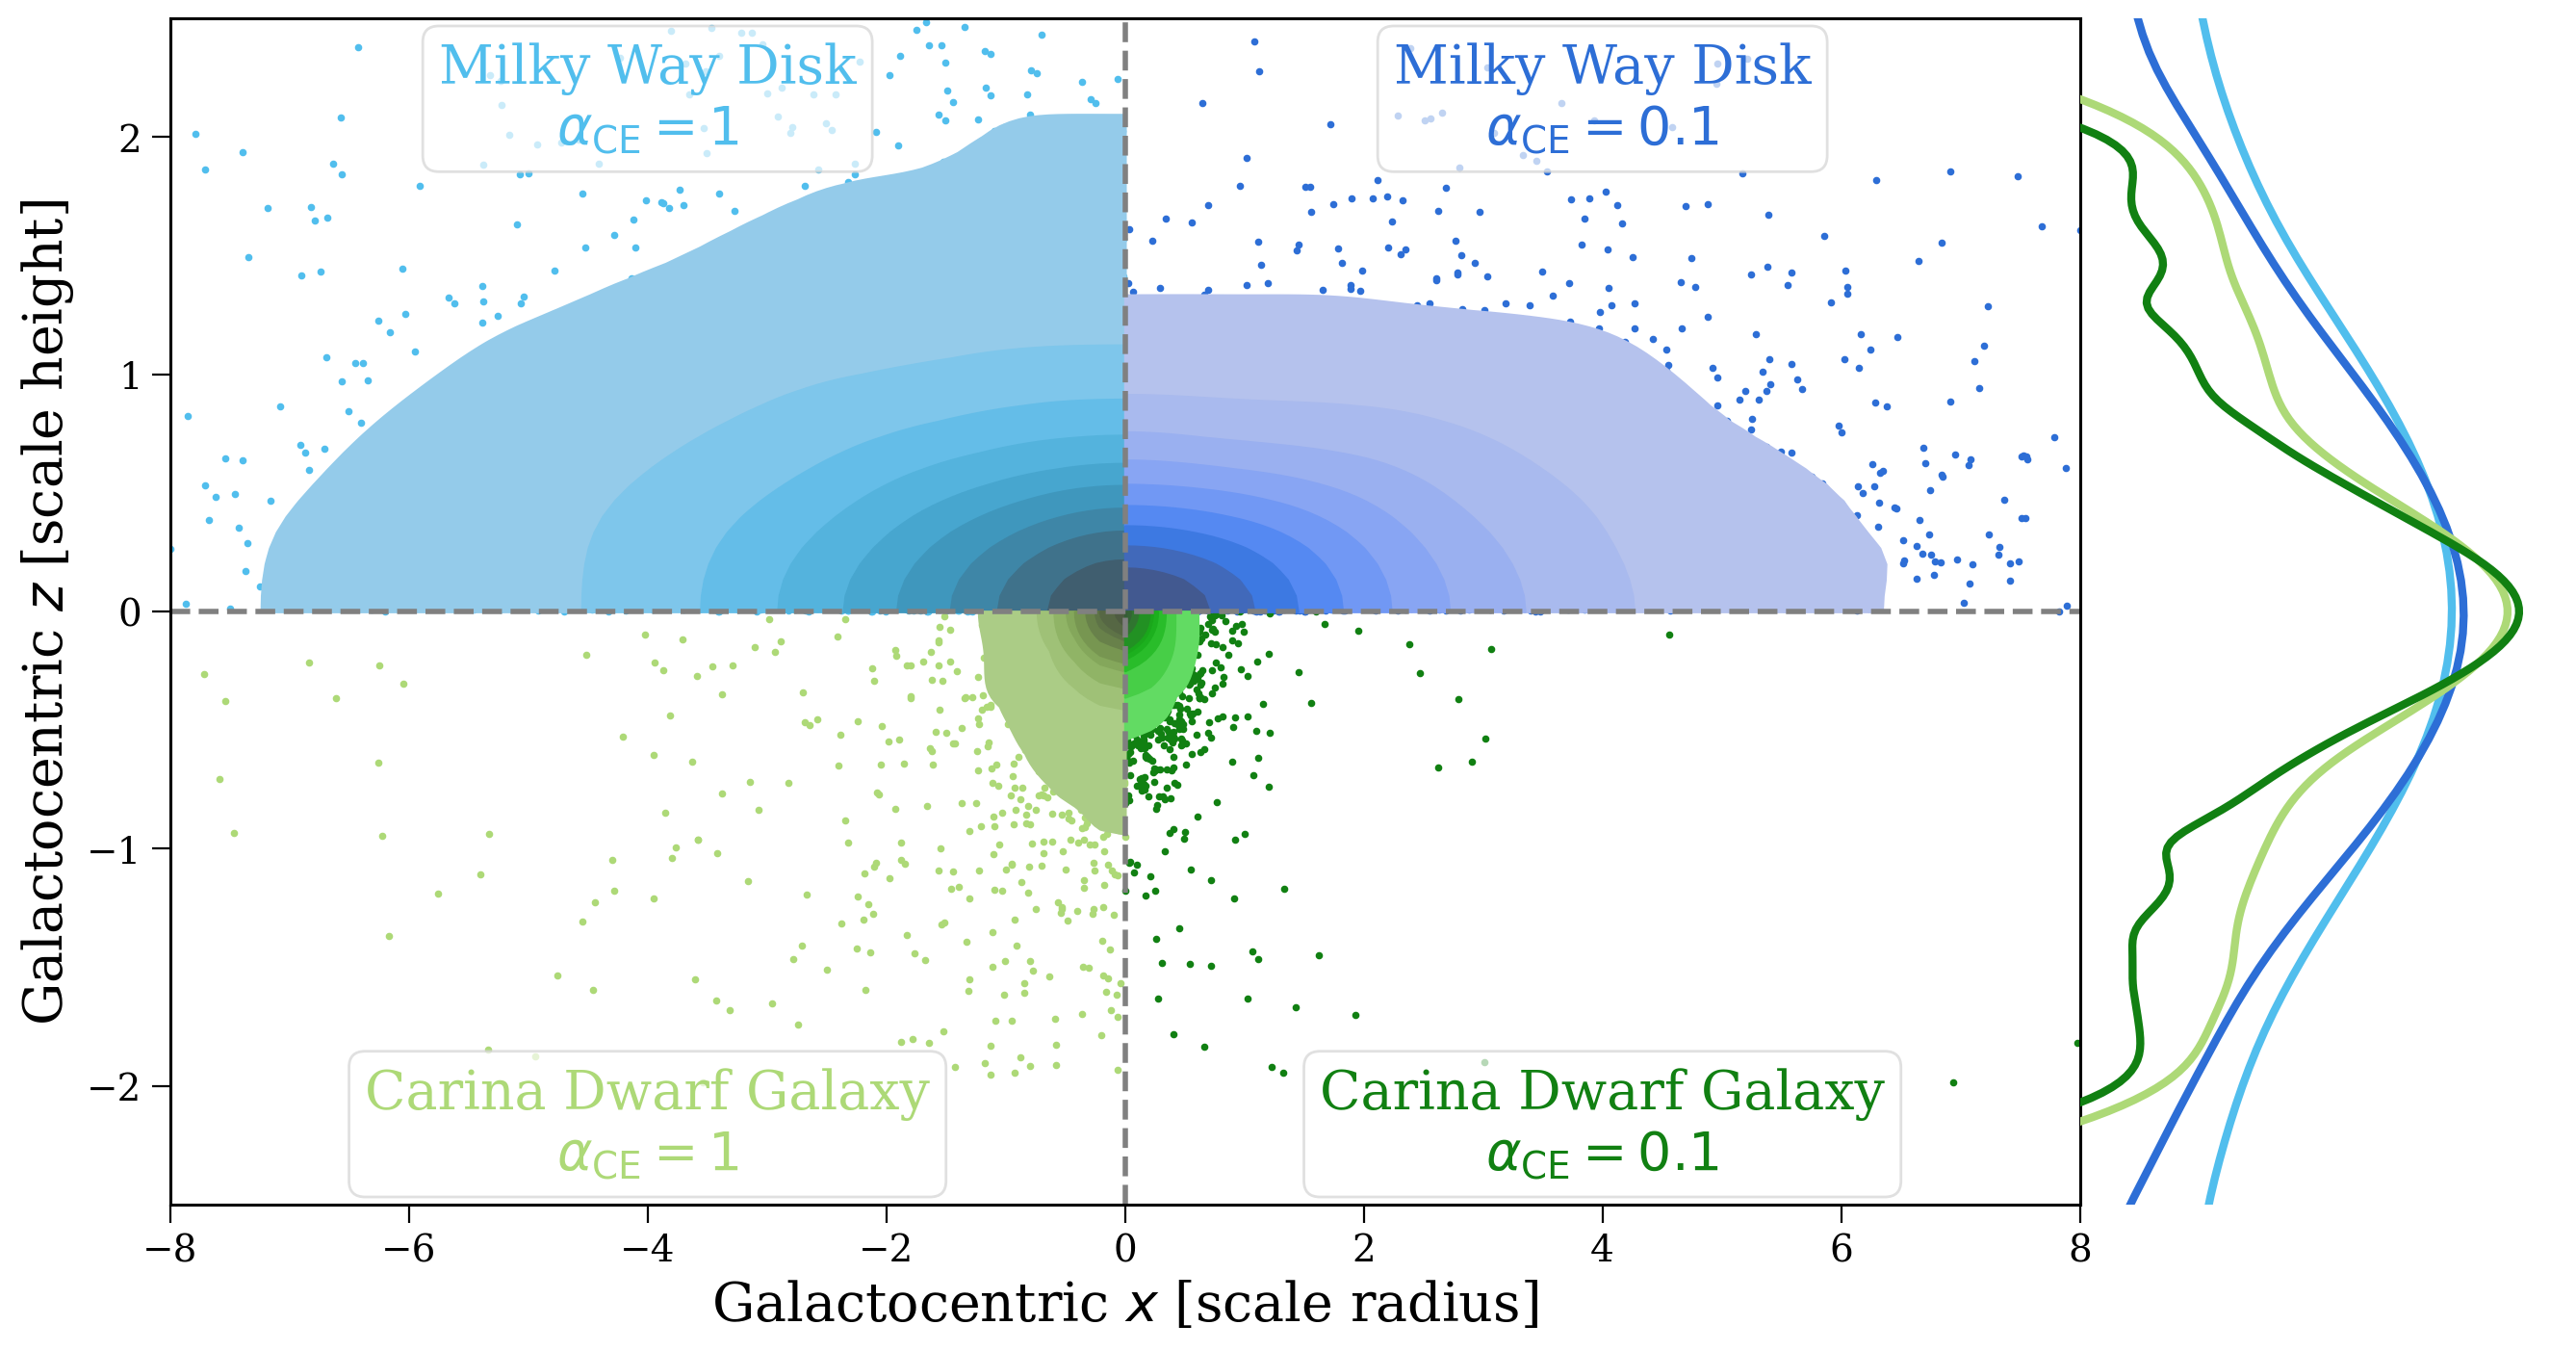

In [79]:
# define colours for the different population
colours = ["#51beed", "#2d6ed6", "#add977", "#118012"]

# iso-probability levels for the density plots
iso_levels = np.linspace(0.05, 1, 10)

# xlims = (min(x_range).value, max(x_range).value)
# zlims = (min(z_range).value, max(z_range).value)
xlims = (-8, 8)
zlims = (-2.5, 2.5)
    
fig, axes = plt.subplots(1, 2, figsize=(16, 8),
                         gridspec_kw={"width_ratios": [4, 1]})

fig.subplots_adjust(hspace=0, wspace=0)

lw = 3
for k, c in zip(data, colours):
    sns.kdeplot(y=data[k]["z"] / data[k]["scale_height"], lw=lw, color=c, ax=axes[1], bw_adjust=2.5)
axes[1].set_xscale("log")
axes[1].set_xlim(left=1e-3)

signs = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
masks = [(X <= 0) & (Z >= 0), (X >= 0) & (Z >= 0), (X <= 0) & (Z <= 0), (X >= 0) & (Z <= 0)]

for c, s, k in zip(colours, signs, data):
    axes[0].scatter(s[0] * np.abs(data[k]["x"]) / data[k]["scale_radius"],
                    s[1] * np.abs(data[k]["z"]) / data[k]["scale_height"],
                    s=3, color=c, rasterized=True)

for i, k in enumerate(data):
    X_mask, Z_mask, d_mask = X[masks[i]].reshape((101, 101)), Z[masks[i]].reshape((101, 101)), data[k]["density"][masks[i]].reshape((101, 101))
    cnt = axes[0].contourf(X_mask / data[k]["scale_radius"], Z_mask / data[k]["scale_height"], d_mask, _iso_level_to_levels(d_mask, iso_levels),
                           cmap=sns.distributions._DistributionPlotter()._cmap_from_color(colours[i]))
    for c in cnt.collections:
        c.set_edgecolor("face")

axes[0].set_xlabel(r"Galactocentric $x$ [scale radius]")
axes[0].set_ylabel(r"Galactocentric $z$ [scale height]")

model_labels=["Milky Way Disk\n" + r"$\alpha_{\rm CE} = 1$",
              "Milky Way Disk\n" + r"$\alpha_{\rm CE} = 0.1$",
              "Carina Dwarf Galaxy\n" + r"$\alpha_{\rm CE} = 1$",
              "Carina Dwarf Galaxy\n" + r"$\alpha_{\rm CE} = 0.1$"]
model_coords = [(0.25, 0.98), (0.75, 0.98), (0.25, 0.02), (0.75, 0.02)]
for l, coords, c in zip(model_labels, model_coords, colours):
    axes[0].annotate(l, xy=coords, xycoords="axes fraction", ha="center",
                     va="top" if coords[1] > 0.5 else "bottom",
                     color=c, fontsize=1*fs, bbox=dict(boxstyle="round", facecolor="white",
                                                          edgecolor="lightgrey", alpha=0.7))

axes[1].axis("off")

axes[0].set_xlim(xlims)
axes[0].set_ylim(zlims)
axes[1].set_ylim(zlims)

axes[0].axvline(0, color="grey", linestyle="--", lw=2)
axes[0].axhline(0, color="grey", linestyle="--", lw=2)

plt.savefig("plots/ce_potential_compare.pdf", bbox_inches="tight", format="pdf")

plt.show()

### Some statistics

Let's check how the FWHM and outliers in the galactic height distributions change.

In [89]:
# loop over the pops and get the FWHM/stats about tails of z distributions
for k in data:
    # calculate a histogram and half its maximum
    counts, bin_edges = np.histogram(data[k]["z"] / data[k]["scale_height"], bins="fd", density=False)
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
    half_max = counts.max() / 2

    # get the fwhm
    indices = np.where(counts >= half_max)[0]
    fwhm = bin_centres[indices[-1]] - bin_centres[indices[0]]

    # count tail fraction
    f = (data[k]["z"] / data[k]["scale_height"] > 1).sum() / len(data[k]["z"])

    print(f"{k}: FWHM={fwhm:.2f}, Fraction > scale height = {f * 100:.1f}%")
    # print()

disc_fiducial: FWHM=0.74, Fraction > scale height = 5.1%
disc_alternate: FWHM=0.74, Fraction > scale height = 3.0%
carina_fiducial: FWHM=0.26, Fraction > scale height = 1.4%
carina_alternate: FWHM=0.28, Fraction > scale height = 0.4%


## Discussion and explanations

Given the variety of results from the four panels, we highlight that both binary physics and the galactic potential can have a strong effect on the resulting spatial distribution of massive stars. In particular, less efficient common-envelope events result in smaller galactic scale heights for massive stars. This is because more stars merge during CEs, such that fewer ejections from disruptions occur and stars stay closer to the plane. In both cases, the overall width of the distribution isn't strongly affected, but the extent of the tails changes significantly. Therefore, observing the outliers in a galactic height distribution can be more informative than the FWHM for inferring the strength of natal kicks.